## European Hotel Review, EDA & NLP Analysis

Hello and welcome to my first Kaggle report. First off, thank you for taking your time to read this. I would greatly appreciate any comments and critiques in regards to my discovery as I am relatively new to Data Science.

As dicussed in the title, this dataset is focussed on European Hotel Reviews. This dataset captures hotel reviews from 08/2015 - 08/2017 all across Europe. As the data describes, there are about 515K reviews and 17 columns. This dataset contains information for each review that someone gives a hotel experience, over the course of 2 years, I track how each hotel's ratings change. My EDA focusses as a time series approach, to understand which hotels improved their review score and which ones didn't. 

I specifically chose this project to tidy up on my R analysis ability with dpylr and ggplot, in addition to exploring NLP sentiment analysis. 

My process is as followed: 

****1. Data Cleanup****
1. Check and replace missing values
2. Add universal variables 
3. split up datasets for EDA and NLP discoveries 

****2. EDA Time series Analysis****
1. Exploring Reviewer Score metric 
2. How reviews change over time
3. How does word count effect review rating 

****3. NLP Sentiment Analysis : ****
1. train and test on whether reviews will positive or negtaive 
2. determine whether written reviews can exlain reviewer score
3. experiment with n-grams 


In [1]:
library(tidyverse)
library(lubridate)
library(stringr)
library(forcats)
library(tidytext)

df = read_csv("../input/Hotel_Reviews.csv")

# check for if any null values are present in which columns 
sapply(df, function(x)sum(is.na(x)))

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0.9000     ✔ purrr   0.3.2     
✔ tibble  2.1.3          ✔ dplyr   0.8.3     
✔ tidyr   0.8.3          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Parsed with column specification:
cols(
  Hotel_Address = col_character(),
  Additional_Number_of_Scoring = col_double(),
  Review_Date = col_character(),
  Average_Score = col_double(),
  Hotel_Name = col_character(),
  Reviewer_Nationality = col_character(),
  Negative_Review = col_character(),
  Review_Total_Negative_Word_Counts = col_double(),
  Total_Number_of_Reviews = col_double(),
  Positive_Review = col_character(),
  Review_Total_Positive_Word_Counts = col_double(),


Hotel_Address 
                                         0 
              Additional_Number_of_Scoring 
                                         0 
                               Review_Date 
                                         0 
                             Average_Score 
                                         0 
                                Hotel_Name 
                                         0 
                      Reviewer_Nationality 
                                       523 
                           Negative_Review 
                                      1002 
         Review_Total_Negative_Word_Counts 
                                         0 
                   Total_Number_of_Reviews 
                                         0 
                           Positive_Review 
                                       194 
         Review_Total_Positive_Word_Counts 
                                         0 
Total_Number_of_Reviews_Reviewer_Has_Given 
                                         0 
                            Reviewer_Score 
                                         0 
                                      Tags 
                                         0 
                         days_since_review 
                                         0 
                                       lat 
                                      3268 
                                       lng 
                                      3268

I know I wont need lat or long since I won't be getting into any geolocation analysis as of right now. 
We will remove these. 

Postive and Negative reviews can both pass for 'nothing said' and most popular country for Reviewer_Nationality.

In [2]:
head(summary(as.factor(df$Reviewer_Nationality)), n = 1) # getting top Nationality for na's  

United Kingdom 
        245246

In [3]:
# can only run once without getting lat & lng errors!
df <- read_csv("../input/Hotel_Reviews.csv")
df <- df %>%
    select(colnames(df), -lat,-lng) %>% 
    mutate(Positive_Review = ifelse(is.na(Positive_Review), 
                                    "Nothing",
                                    Positive_Review)) %>%
    mutate(Negative_Review = ifelse(is.na(Negative_Review), 
                                    "Nothing",
                                    Negative_Review)) %>%
    mutate(Reviewer_Nationality = ifelse(is.na(Reviewer_Nationality), 
                                    "United Kingdom",
                                    Reviewer_Nationality))

sapply(df, function(x)sum(is.na(x)))
       # good no more NAs!

Parsed with column specification:
cols(
  Hotel_Address = col_character(),
  Additional_Number_of_Scoring = col_double(),
  Review_Date = col_character(),
  Average_Score = col_double(),
  Hotel_Name = col_character(),
  Reviewer_Nationality = col_character(),
  Negative_Review = col_character(),
  Review_Total_Negative_Word_Counts = col_double(),
  Total_Number_of_Reviews = col_double(),
  Positive_Review = col_character(),
  Review_Total_Positive_Word_Counts = col_double(),
  Total_Number_of_Reviews_Reviewer_Has_Given = col_double(),
  Reviewer_Score = col_double(),
  Tags = col_character(),
  days_since_review = col_character(),
  lat = col_double(),
  lng = col_double()
)


Hotel_Address 
                                         0 
              Additional_Number_of_Scoring 
                                         0 
                               Review_Date 
                                         0 
                             Average_Score 
                                         0 
                                Hotel_Name 
                                         0 
                      Reviewer_Nationality 
                                         0 
                           Negative_Review 
                                         0 
         Review_Total_Negative_Word_Counts 
                                         0 
                   Total_Number_of_Reviews 
                                         0 
                           Positive_Review 
                                         0 
         Review_Total_Positive_Word_Counts 
                                         0 
Total_Number_of_Reviews_Reviewer_Has_Given 
                                         0 
                            Reviewer_Score 
                                         0 
                                      Tags 
                                         0 
                         days_since_review 
                                         0

Now that we have no more nulls, I want to add data I think may be necessary for analysis to the dataset before I subset them. 

In [4]:
df <- df %>%
  mutate(Review_Date = lubridate::mdy(Review_Date))

#summary(df)

# Time Series Analysis 
# is the score dependent on time of year? 

df <- df %>%
  mutate(Year = year(Review_Date)) %>%
  mutate(Month = month(Review_Date))

# credit to fellow kaggle user, GunnvantSaini
df <- df %>% 
  mutate(Country = sapply(str_split(Hotel_Address," "),function(x){x[length(x)]}))

Finally subsetting the two pieces of data into NLP and EDA groups. 

In [5]:
# subsetting out lengthy columns, keeping hotel address and review data if
# needed to join
df_nlp <- df %>%
    select(Hotel_Name, Country, Review_Date, Year, Month,  
    Total_Number_of_Reviews_Reviewer_Has_Given, Negative_Review,
    Review_Total_Negative_Word_Counts,Reviewer_Nationality,
    Positive_Review, Review_Total_Positive_Word_Counts,  
    Total_Number_of_Reviews_Reviewer_Has_Given, Tags, Reviewer_Score)

df_eda <- df %>%
    select(Hotel_Name, Country, Review_Date, Year, Month, Average_Score,
    Reviewer_Nationality,Reviewer_Score,Total_Number_of_Reviews_Reviewer_Has_Given)

print("First 6 columns for EDA:" )
head(df_eda)

print("First column of NLP:" )
head(df_nlp, n = 1)

[1] "First 6 columns for EDA:"


Hotel_Name,Country,Review_Date,Year,Month,Average_Score,Reviewer_Nationality,Reviewer_Score,Total_Number_of_Reviews_Reviewer_Has_Given
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Hotel Arena,Netherlands,2017-08-03,2017,8,7.7,Russia,2.9,7
Hotel Arena,Netherlands,2017-08-03,2017,8,7.7,Ireland,7.5,7
Hotel Arena,Netherlands,2017-07-31,2017,7,7.7,Australia,7.1,9
Hotel Arena,Netherlands,2017-07-31,2017,7,7.7,United Kingdom,3.8,1
Hotel Arena,Netherlands,2017-07-24,2017,7,7.7,New Zealand,6.7,3
Hotel Arena,Netherlands,2017-07-24,2017,7,7.7,Poland,6.7,1


[1] "First column of NLP:"


Hotel_Name,Country,Review_Date,Year,Month,Total_Number_of_Reviews_Reviewer_Has_Given,Negative_Review,Review_Total_Negative_Word_Counts,Reviewer_Nationality,Positive_Review,Review_Total_Positive_Word_Counts,Tags,Reviewer_Score
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
Hotel Arena,Netherlands,2017-08-03,2017,8,7,I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin your holiday So we had to wait till 13 00 in order to check in my new room what a wonderful waist of my time The room 023 i got was just as i wanted to peaceful internal garden view big window We were tired from waiting the room so we placed our belongings and rushed to the city In the evening it turned out that there was a constant noise in the room i guess it was made by vibrating vent tubes or something it was constant and annoying as hell AND it did not stop even at 2 am making it hard to fall asleep for me and my wife I have an audio recording that i can not attach here but if you want i can send it via e mail The next day the technician came but was not able to determine the cause of the disturbing sound so i was offered to change the room once again the hotel was fully booked and they had only 1 room left the one that was smaller but seems newer,397,Russia,Only the park outside of the hotel was beautiful,11,"[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 6 nights ']",2.9


As we can see some of the Review columns can be quite lengthy, we will work with these features later. 

## Time Series EDA Analysis 

For my EDA, I wanted to gain a good understanding first of how review scores are distributed among the different hotels. Review score will be the main variable I want to base the performance of hotels on. 

First, I want to understand how the distribution of scores is. 

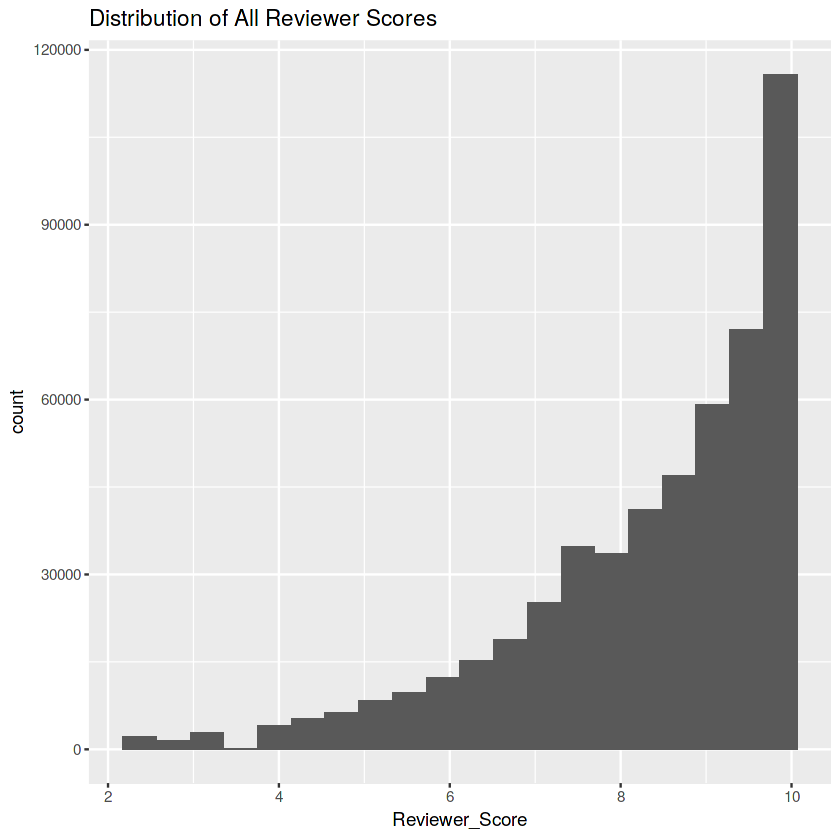

In [6]:
ggplot(df_eda, aes(Reviewer_Score))+
  geom_histogram(bins = 20) +
  ggtitle("Distribution of All Reviewer Scores")

We know not all hotels are created equally. While Average_Score can be a good indicator of these hotel's average performance, but as statisticans we know that without information about variable distriubtion we cannot rely on an average to give us all the insight on Hotel Performance. 

If we knew the standarded deviation of each hotel brand in addition to the mean, we would be able to label these hotels much better for which ones are truly producing the best customer service. 

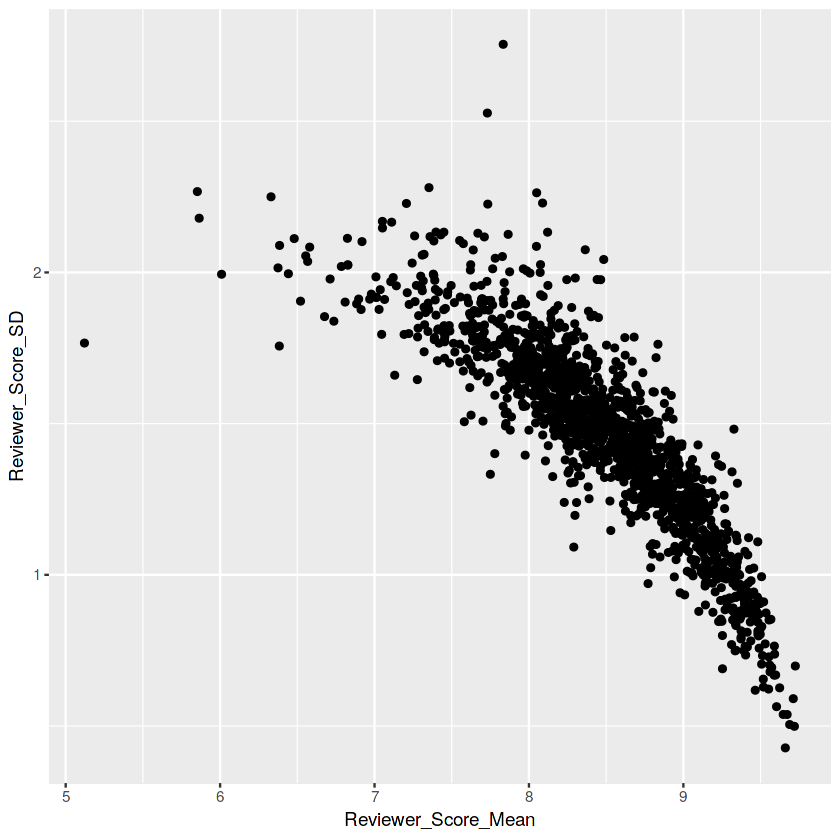

In [7]:
df_hotel_performance <- df %>%
    select(Hotel_Name, Country, Reviewer_Nationality, Reviewer_Score, Year, Month) %>%
    group_by(Hotel_Name) %>% 
    summarise(Reviewer_Score_Mean = mean(Reviewer_Score), Reviewer_Score_SD = sd(Reviewer_Score))

ggplot(df_hotel_performance, aes(Reviewer_Score_Mean, Reviewer_Score_SD)) + 
    geom_point()

This visual actually how there is a strong negative correlation betwee Reviewer_Score_Average and a low Standard Deviation. Hotels that recieve higher rating averages likely vary less in deviation of reviews while lower quality hotels have a bigger range of what they expect guests to rate the hotel. May be explained by less consistentency in customer service giving guests a less consistent user experience. 



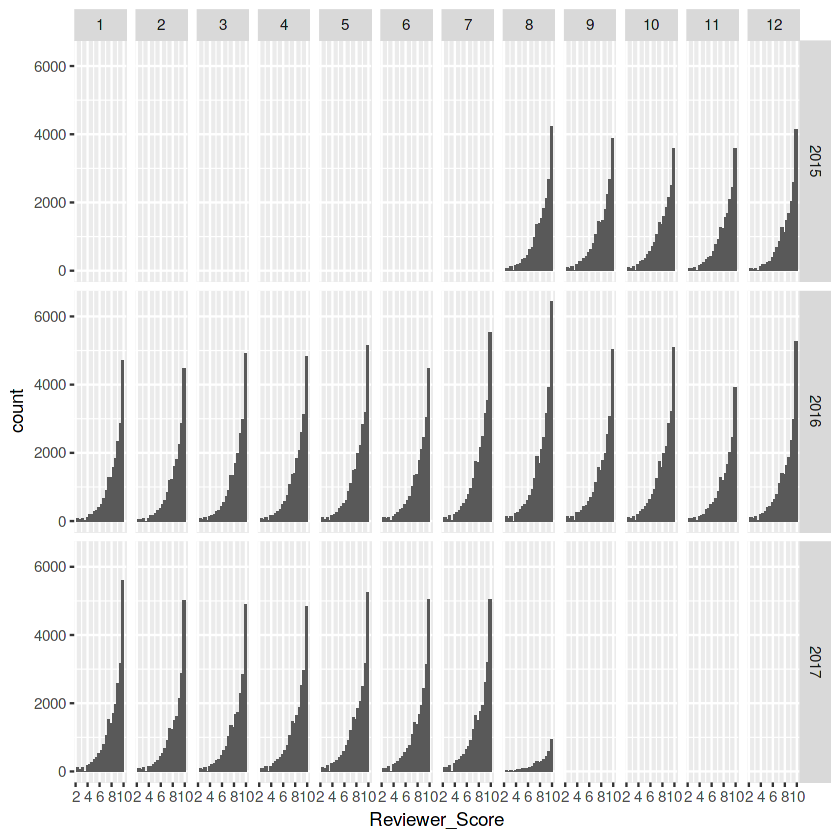

In [8]:
ggplot(df_eda, aes(Reviewer_Score)) +
  geom_histogram(bins = 20) + 
  facet_grid(Year~Month)

Visually it is hard to observe a time series analysis of Histograms, so I for each month of each year, I grouped together the mean and standard deviation of the Reviewer_Scores. 

Per the below graphic, 2016 has the highest concentration in the bottom left corner, demonstrating, not with respect to hotels opening or closing during the year span, that during 2016 all hotels on average recieved a higher average review score with a small spread of reviews.   

It is important to note that because 2016 is the only Year in which all months are recorded, we cannot use this data to explain any differences on why 2016's averages higher than the other years. For example, if in early Febuary of 2015 there was an unrecorded boom in Hotel Attendence, we have no representation of that even incurring because of our limited date range.  

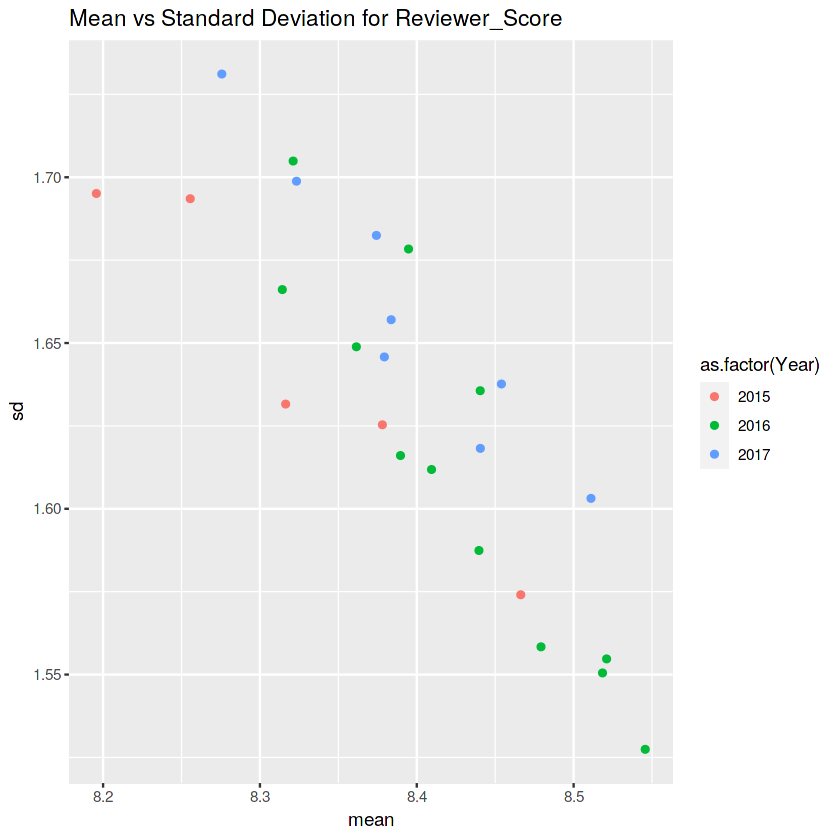

In [9]:
df_Year_Month_Summary <- df_eda %>%
  select(Year,Month, Reviewer_Score) %>%
  group_by(Year, Month) %>%
  summarise(sd = sd(Reviewer_Score), mean = mean(Reviewer_Score)) %>%
  arrange(Year, Month) 


ggplot(df_Year_Month_Summary, aes(mean, sd, color = as.factor(Year))) + 
  geom_point() + 
  ggtitle("Mean vs Standard Deviation for Reviewer_Score")


With the above being said, it would be ideal to hold time varying factors from each month and year constant, this dataset does not have much information regarding time varying factors. 

We will take a more generalized approach to a hotel score while preparing to transition to an NLP analysis. 
For example, We already have our review comments divided into a Positive and Negative category along with word count for each of these categories already summed. 

[1] "Hotel_Name"                                
 [2] "Country"                                   
 [3] "Review_Date"                               
 [4] "Year"                                      
 [5] "Month"                                     
 [6] "Total_Number_of_Reviews_Reviewer_Has_Given"
 [7] "Negative_Review"                           
 [8] "Review_Total_Negative_Word_Counts"         
 [9] "Reviewer_Nationality"                      
[10] "Positive_Review"                           
[11] "Review_Total_Positive_Word_Counts"         
[12] "Tags"                                      
[13] "Reviewer_Score"

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


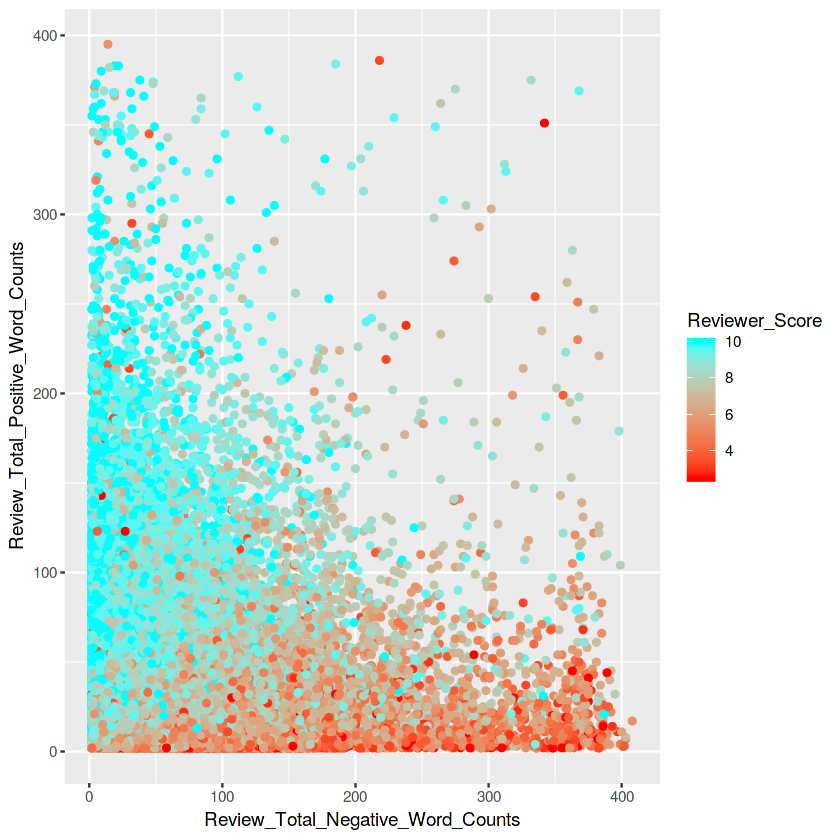

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


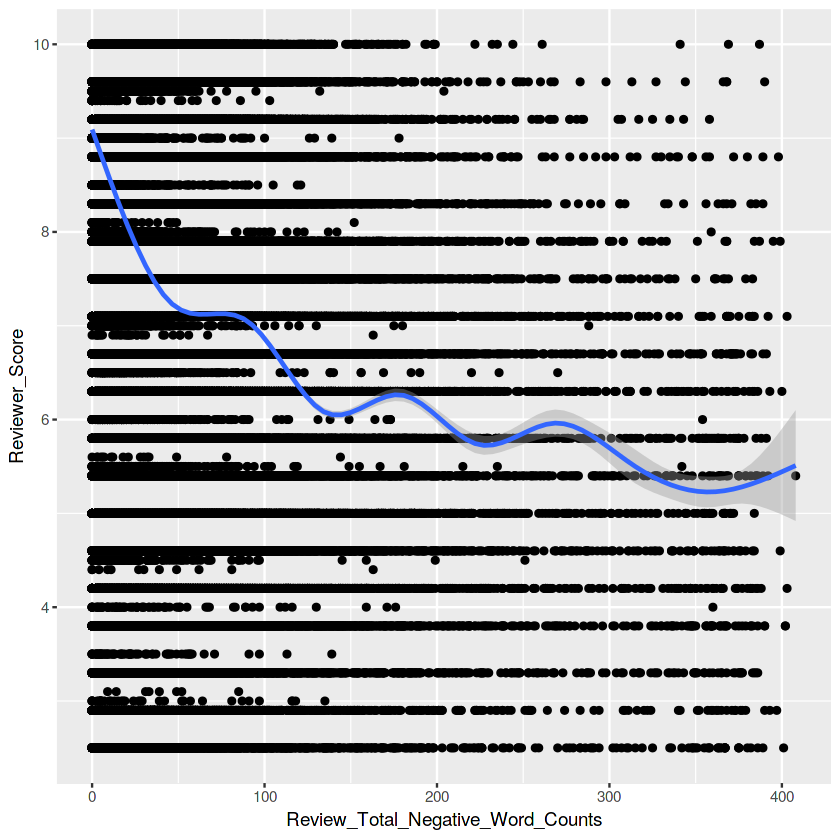

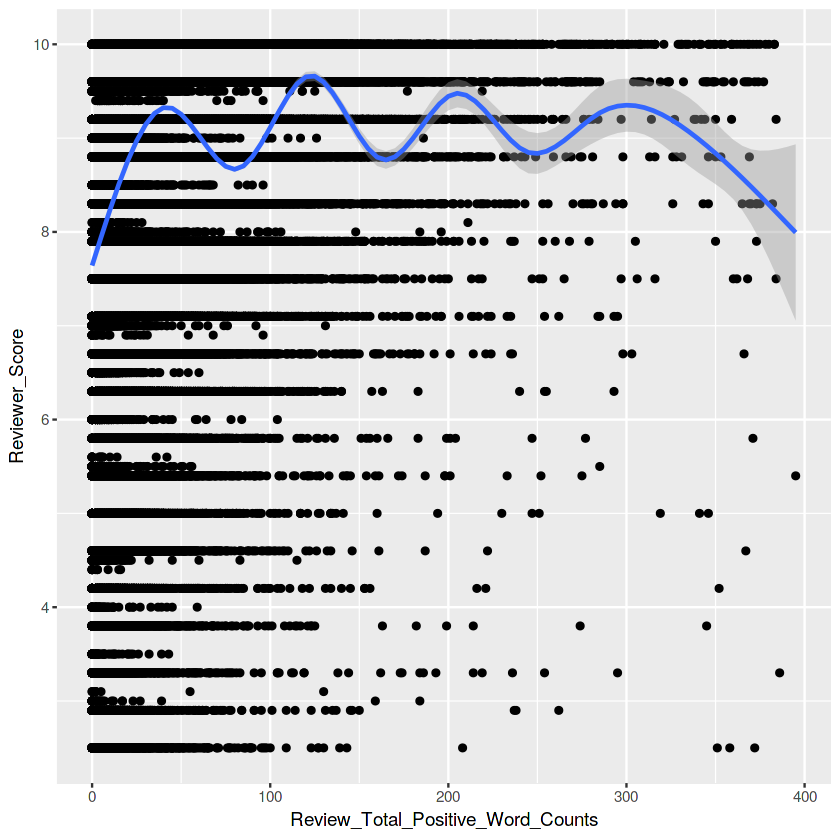

In [10]:
colnames(df_nlp)

df_nlp_words <- df_nlp %>%
    select(Total_Number_of_Reviews_Reviewer_Has_Given, 
           Review_Total_Negative_Word_Counts, 
           Review_Total_Positive_Word_Counts, Reviewer_Score, Reviewer_Nationality) %>% 
    filter(Review_Total_Negative_Word_Counts > 0 & 
           Review_Total_Positive_Word_Counts > 0)

ggplot(df_nlp_words, aes(Review_Total_Negative_Word_Counts, Review_Total_Positive_Word_Counts)) + 
    geom_point( aes(color = Reviewer_Score))+ 
    scale_colour_gradientn(colours=rainbow(2))

ggplot(df_nlp, aes(Review_Total_Negative_Word_Counts, Reviewer_Score)) + 
    geom_point( ) + 
    geom_smooth()
ggplot(df_nlp, aes(Review_Total_Positive_Word_Counts, Reviewer_Score)) + 
    geom_point( ) + 
    geom_smooth()


This visual gives a good explanation of how word count can be a great indicator of what score the reviewer gives the hotel. 

By adding geom_smooth to both of the scatter plots of word count vs reviewer score, you're able to asses population distribution much easier as well. For both Positive and Negative Word counts the trend lines are as expected and it's interesting how when negative word count is at zero, the rating averages to a 9, but when positive word count is at zero, the average is below an 8. 

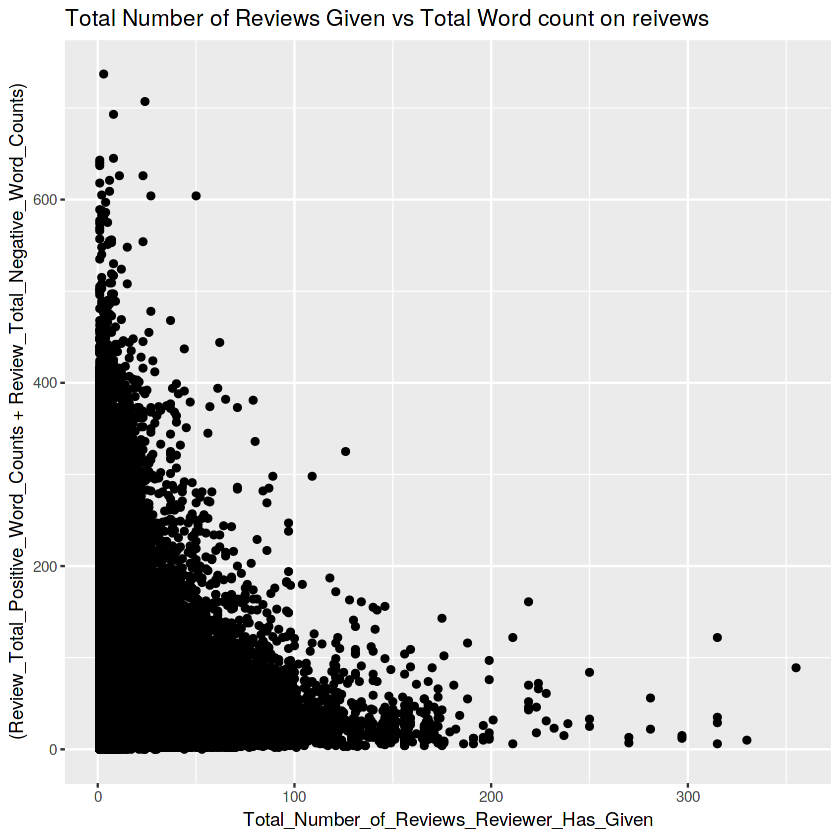

In [11]:
ggplot(df_nlp, aes(Total_Number_of_Reviews_Reviewer_Has_Given, 
                   (Review_Total_Positive_Word_Counts + Review_Total_Negative_Word_Counts))) + 
    geom_point() + 
    ggtitle("Total Number of Reviews Given vs Total Word count on reivews")

## Natural Language Processing

In my NLP analysis, first I will create a dataset and concatenate both negative and positive reviews and indicate with a 1 or 0 if the review was positive or negative. 



In [12]:
# With the help from Introduction to Data Science Udemy video  

df_reviews_pos <- df_nlp %>% 
  mutate(Review = Positive_Review) %>% 
  mutate(Word_Count = Review_Total_Positive_Word_Counts) %>% 
  mutate(Review_Type = 'Positive')%>% 
  filter(Word_Count > 0) %>%
  select(Review, Word_Count, Review_Type)

df_reviews_neg <- df_nlp  %>% 
  mutate(Review = Negative_Review) %>% 
  mutate(Word_Count = Review_Total_Negative_Word_Counts) %>% 
  mutate(Review_Type = 'Negative')%>% 
  filter(Word_Count > 0) %>%
  select(Review, Word_Count, Review_Type)

df_reviews <- rbind(data.frame(df_reviews_neg, stringsAsFactors = F, isPositive = 0), 
                    data.frame(df_reviews_pos, stringsAsFactors = F, isPositive = 1))

Creating training and testing subsets of the data that we can further break down into bigrams for sentiment analysis. 

In [13]:
set.seed(42)
sample <- sample.int(n = nrow(df_reviews), size = floor(.8*nrow(df_reviews)), replace = F)
reviews_train <- df_reviews[sample, ]
reviews_test <- df_reviews[-sample, ]


n <- nrow(reviews_train)
nY <- sum(reviews_train$isPositive)
nN <- n-nY
toks <- reviews_train %>% 
  unnest_tokens(output = bigram, input = Review, token = "ngrams", n = 2)

Removing stop words like (and, or, I etc) are so that you retain specific words and removes those that don't provide value without context. 

Binding the bigrams together and running bind_tf_idf() allows me to see how frequent each bigram is in the category, the inverse category's frequency, and the product of the frequency and inverse frequency. This variable, tf_idf is a good indicator of what words are only specific to a specific category, which in our case would be a Positive or Negative comment.  

In [14]:
data("stop_words")

toks_sep <- toks %>% 
  separate(bigram, c("word1","word2"), sep = " ") %>%
  group_by(isPositive) %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>% 
  filter(word1 != word2) %>% 
  count(word1, word2, sort = TRUE) 

toks_bind <- toks_sep %>%
  unite(bigram, word1, word2, sep = " ")

toks_bind <- toks_bind %>%
  group_by(isPositive) %>%
  bind_tf_idf(bigram, isPositive, n) %>%
  arrange(desc(tf_idf))

toks_bind$bigram <- factor(toks_bind$bigram) %>% fct_reorder(toks_bind$tf_idf)
toks_bind$isPositive <- as.factor(toks_bind$isPositive)

head(toks_bind)

isPositive,bigram,n,tf,idf,tf_idf
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
1,bed excellent,538,0.0004466198,0.6931472,0.0003095733
1,location comfy,394,0.0003270784,0.6931472,0.0002267135
1,comfortable excellent,389,0.0003229277,0.6931472,0.0002238364
1,breakfast comfortable,386,0.0003204373,0.6931472,0.0002221102
1,staff comfy,382,0.0003171167,0.6931472,0.0002198085
1,location comfort,367,0.0003046644,0.6931472,0.0002111773


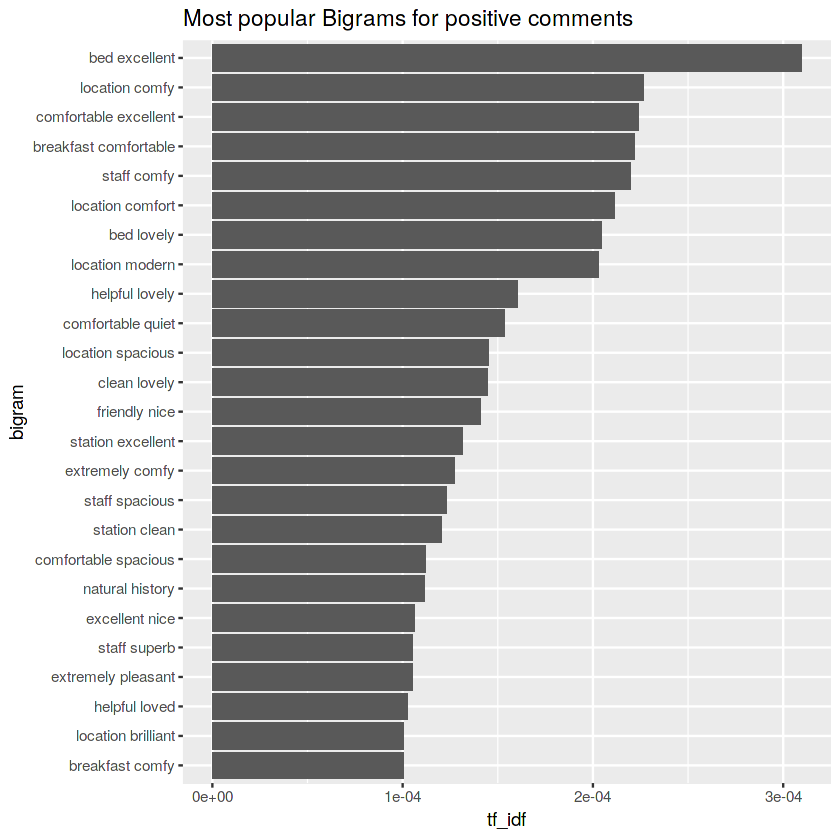

In [15]:
toks_bind %>% filter(isPositive == 1) %>% head(25) %>% 
ggplot(aes(bigram, tf_idf)) + geom_col() + coord_flip() + 
  ggtitle("Most popular Bigrams for positive comments")

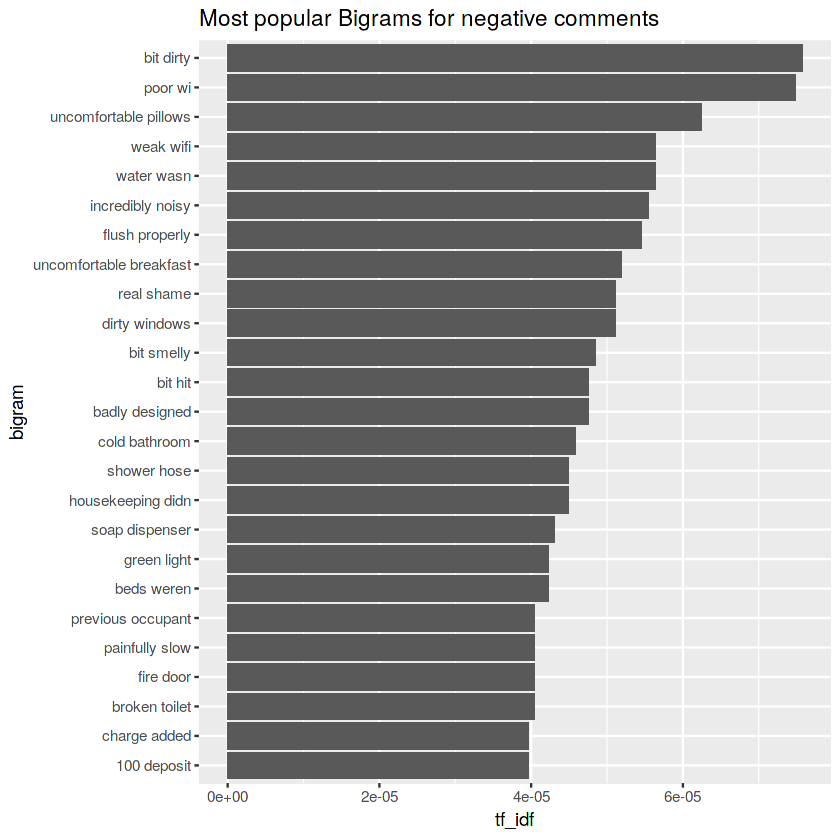

In [16]:
toks_bind %>% filter(isPositive == 0)  %>% head(25) %>%
  ggplot(aes(bigram, tf_idf)) + geom_col() + coord_flip() + 
  ggtitle("Most popular Bigrams for negative comments")